In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import nltk.corpus
import string
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier 
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, roc_curve
import pickle

%matplotlib inline

In [2]:
fake = pd.read_csv('Fake.csv')
fake['category'] = 'Fake'
fake.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


In [3]:
true = pd.read_csv('True.csv')
true['category'] = 'True'
true.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True


In [4]:
print(true['subject'].unique())
print(fake['subject'].unique())
print(fake.shape, true.shape)

['politicsNews' 'worldnews']
['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
(23481, 5) (21417, 5)


In [5]:
tf = fake.append(true, ignore_index=True)
print(tf.shape)
tf.head()

(44898, 5)


,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


In [6]:
df = tf.sample(frac=1).reset_index(drop=True)
df.to_csv("News_data.csv")

In [7]:
df.drop('date',axis=1, inplace=True)
df.head()

,title,text,subject,category
0,AWESOME! ATTORNEY GENERAL JEFF SESSIONS Just D...,#FlashbackFriday 1993 #AttorneyGate Clinton AG...,politics,Fake
1,Racists Call For Deaths Of Black People After...,Emotions around the nation are raw due to the ...,News,Fake
2,Exclusive: Trump could seek new law to purge g...,CLEVELAND (Reuters) - If he wins the presidenc...,politicsNews,True
3,[VIDEO] DINESH D’SOUZA Warned Us About What Th...,Dinesh made some frightening predictions in hi...,left-news,Fake
4,BLACK WOMAN IN CHARLESTON WARNS “There’s gonna...,All the progress that s been made with race re...,politics,Fake


In [8]:
print('Null values for each column')
print(df.isnull().sum())
print
df['subject'].value_counts()

Null values for each column
title       0
text        0
subject     0
category    0
dtype: int64


politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

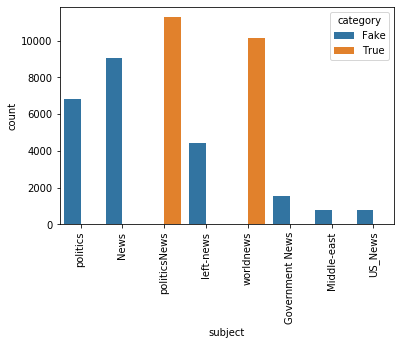

In [9]:
sns.countplot(df.subject, data=df, hue=df.category)
plt.xticks(rotation="vertical")

In [10]:
df.drop('subject', axis=1, inplace=True)
df.head()

,title,text,category
0,AWESOME! ATTORNEY GENERAL JEFF SESSIONS Just D...,#FlashbackFriday 1993 #AttorneyGate Clinton AG...,Fake
1,Racists Call For Deaths Of Black People After...,Emotions around the nation are raw due to the ...,Fake
2,Exclusive: Trump could seek new law to purge g...,CLEVELAND (Reuters) - If he wins the presidenc...,True
3,[VIDEO] DINESH D’SOUZA Warned Us About What Th...,Dinesh made some frightening predictions in hi...,Fake
4,BLACK WOMAN IN CHARLESTON WARNS “There’s gonna...,All the progress that s been made with race re...,Fake


In [11]:
df['category'].value_counts() #checking if the dataset is an imbalanced one

Fake    23481
True    21417
Name: category, dtype: int64

In [12]:
#prepping the data for machine learning, removing punctuation and stop words
def text_cleaning(text):
    remove_punctuation = [char for char in text if char not in string.punctuation] #removing punctuation from each message
    remove_punctuation = ''.join(remove_punctuation) #joins each word back to make a sentence
    return [word for word in remove_punctuation.split() if word.lower() not in stopwords.words('english')] #eliminate english stop words

In [13]:
train, test = np.split(df.sample(frac=1, random_state=1), [int(0.70*len(df))])
# train_data.to_csv('train_data.csv')
# test_data.to_csv('test_data.csv')
print(train.shape, test.shape)

(31428, 3) (13470, 3)


In [14]:
train['category'].replace('True', 'Real', inplace=True)
train.head()

,title,text,category
4528,Trump has 'friendly' call with Mexican leader ...,WASHINGTON (Reuters) - The presidents of the U...,Real
31727,WHICH ONE OF THESE PEOPLE Tried to Lecture the...,,Fake
10937,House Republicans Give Themselves The Power T...,It s only been a couple days since Republicans...,Fake
13470,"Trump, Republicans to showcase tax cut for bus...",WASHINGTON (Reuters) - U.S. President Donald T...,Real
40814,WATCH: Democratic Rep SHREDS Republicans For ...,Republicans are poised to take healthcare away...,Fake


In [15]:
train = train.reset_index(drop=True)

In [16]:
x = train['text'].iloc[0:3000]
y = train['category'].iloc[0:3000]

vectorizer = CountVectorizer(analyzer=text_cleaning).fit(x) #Vectorizing and counting words for each sample
vector = vectorizer.transform(x)

tfidf = TfidfTransformer().fit(vector) #TF-IDF Term Frequency Inverse Document Frequency, to find out the most important words in a sample
X = tfidf.transform(vector)
X.shape

(3000, 58342)

Building the model 

In [17]:
y = y.map({'Real':1, 'Fake':0}) #label encoding with the map function

In [18]:
print(y.value_counts())

0    1579
1    1421
Name: category, dtype: int64


In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) #split the train data into train and test

In [20]:
lg = LogisticRegression(random_state=0)
mn = MultinomialNB()
gn = GaussianNB()
gb = PassiveAggressiveClassifier()
xg = xgb.XGBClassifier(max_depth=4, eta=0.3, objective='multi:softmax', num_class=2)

In [21]:
lg.fit(x_train,y_train)
lg_pred = lg.predict(x_test)
print('Accuracy score', accuracy_score(list(y_test.values), lg_pred))
print('Precision score', precision_score(list(y_test.values), lg_pred))
print('Recall score', recall_score(list(y_test.values), lg_pred))
print('F1 score', f1_score(list(y_test.values), lg_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), lg_pred))

Accuracy score 0.9716666666666667
Precision score 0.9719298245614035
Recall score 0.9685314685314685
F1 score 0.9702276707530647
Confusion Matrix: 
 [[306   8]
 [  9 277]]


In [22]:
xg.fit(x_train,y_train)
xg_pred = xg.predict(x_test)
print('Accuracy score', accuracy_score(list(y_test.values), xg_pred))
print('Precision score', precision_score(list(y_test.values), xg_pred))
print('Recall score', recall_score(list(y_test.values), xg_pred))
print('F1 score', f1_score(list(y_test.values), xg_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), xg_pred))

[11:19:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score 0.9933333333333333
Precision score 0.9862068965517241
Recall score 1.0
F1 score 0.9930555555555556
Confusion Matrix: 
 [[310   4]
 [  0 286]]


In [23]:
gb.fit(x_train,y_train)
gb_pred = gb.predict(x_test)
print('Accuracy score', accuracy_score(list(y_test.values), gb_pred))
print('Precision score', precision_score(list(y_test.values), gb_pred))
print('Recall score', recall_score(list(y_test.values), gb_pred))
print('F1 score', f1_score(list(y_test.values), gb_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), gb_pred))

Accuracy score 0.985
Precision score 0.9792387543252595
Recall score 0.9895104895104895
F1 score 0.9843478260869565
Confusion Matrix: 
 [[308   6]
 [  3 283]]


In [24]:
mn.fit(x_train,y_train)
mn_pred = mn.predict(x_test)
print('Accuracy score', accuracy_score(list(y_test.values), mn_pred))
print('Precision score', precision_score(list(y_test.values), mn_pred))
print('Recall score', recall_score(list(y_test.values), mn_pred))
print('F1 score', f1_score(list(y_test.values), mn_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), mn_pred))

Accuracy score 0.9566666666666667
Precision score 0.9362416107382551
Recall score 0.9755244755244755
F1 score 0.9554794520547946
Confusion Matrix: 
 [[295  19]
 [  7 279]]


### Plotting ROC curve to visualize metrics

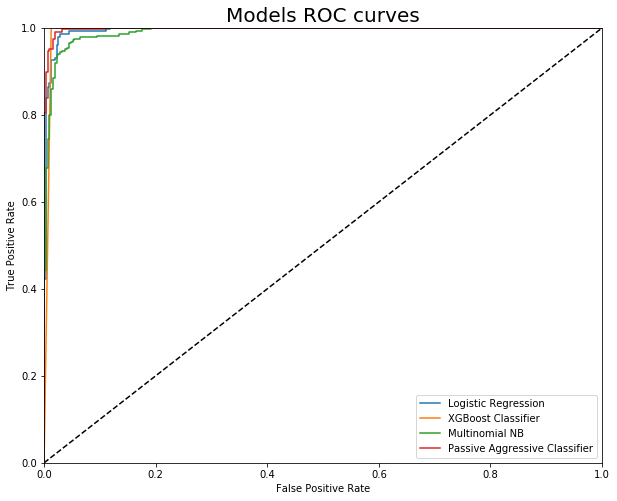

In [25]:
lg_score = lg.decision_function(x_test)
xg_score = xg.predict_proba(x_test)[:,1]
mn_score = mn.predict_proba(x_test)[:,1]
gb_score = gb.decision_function(x_test)

# Getting the ROC curve for each classifier used
fpr_lg, tpr_lg, threshold_lg = roc_curve(y_test.values, lg_score)
fpr_xg, tpr_xg, threshold_xg = roc_curve(y_test.values, xg_score)
fpr_mn, tpr_mn, threshold_mn = roc_curve(y_test.values, mn_score)
fpr_gb, tpr_gb, threshold_gb = roc_curve(y_test.values, gb_score)

#plotting each in curve in a single plot for better understanding
plt.figure(figsize=(10,8))
plt.plot([0,1], [0,1], color='k', linestyle='--')
plt.plot(fpr_lg, tpr_lg, label='Logistic Regression')
plt.plot(fpr_xg, tpr_xg, label='XGBoost Classifier')
plt.plot(fpr_mn, tpr_mn, label='Multinomial NB')
plt.plot(fpr_gb, tpr_gb, label='Passive Aggressive Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Models ROC curves', fontsize=20)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')

plt.legend()

Confusion Matrix:
 [[310   4]
 [  0 286]]


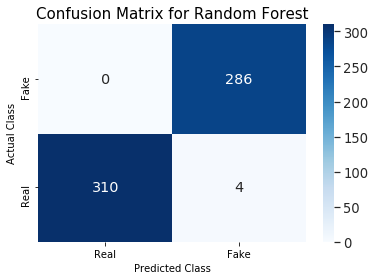

In [26]:
#Visualizing confusion matrix for xgboost Classifier
xticks=['Real', 'Fake']
yticks=['Real', 'Fake']
conf_m = confusion_matrix(list(y_test.values), xg_pred)
print('Confusion Matrix:\n',conf_m)
plt.figure()
plt.title('Confusion Matrix for Random Forest', fontsize=15)
sns.set(font_scale=1.2)
ax=sns.heatmap(conf_m, fmt='d', xticklabels=xticks, yticklabels=yticks, annot=True, cmap='Blues')
ax.set_ylim([0,2])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

It was already obvious that xgboost provides the best accuracy of a 100%, the roc plotting above is just to visualize this, in essence, there wont be any need for scalling the data and training again or any hyperparameter optimization of xgboost, since its our preferred model, we'll just move straight to pickling and deploying

In [27]:
#Saving the prefered classifier
with open('xgb.pk1', 'wb') as model:
    pickle.dump(xg, model)

In [28]:
with open('pac.pk1', 'wb') as model_2:
    pickle.dump(gb, model_2)